# SETI Breaktrhough Listen

In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from torch.utils.data.sampler import WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold

In [4]:
torch.cuda.empty_cache()

### Config

In [5]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 10,
    "folds": 5,

    "transfer_model_name": "efficientnet-b1",
    "efficientnet_pth": "efficientnet-b1-dbc7070a.pth",
    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 256,
    "width": 256,

    "origin_height": 273,
    "origin_width": 256,

    "use_all": True,
    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [6]:
def set_seed(seed=0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state
random_state = set_seed(2021)

In [16]:
df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
df_train['img_path'] = df_train['id'].apply(lambda x:f'{conf_dict["input_dir"]}{x[0]}/{x}.npy')

### Visualize Data

In [18]:
def get_imagefile_by_id(id: str) -> str:
	return f'{conf_dict["input_dir"]}{id[0]}/{id}.npy'

def plot_cadence(id: str, filename: str, target: int) -> None:
	plt.figure(figsize = (10, 10))
	arr = np.load(filename)

	for i in range(6):
		plt.subplot(6, 1, i + 1)
		if i == 0:
			plt.title(f'ID: {id} TARGET: {target}', fontsize = 18)
		plt.imshow(arr[i].astype(float), interpolation = 'nearest', aspect = 'auto')
		plt.text(5, 100, ['ON', 'OFF'][i % 2], bbox = {'facecolor': 'white'})
		plt.xticks([])
	plt.show()

def display_cadence(data, n_sample: int, target: int) -> None:
	data = data[data['target'] == target].sample(n_sample)
	for idx, row in data.iterrows():
		plot_cadence(row['id'], get_imagefile_by_id(row['id']), row['target'])

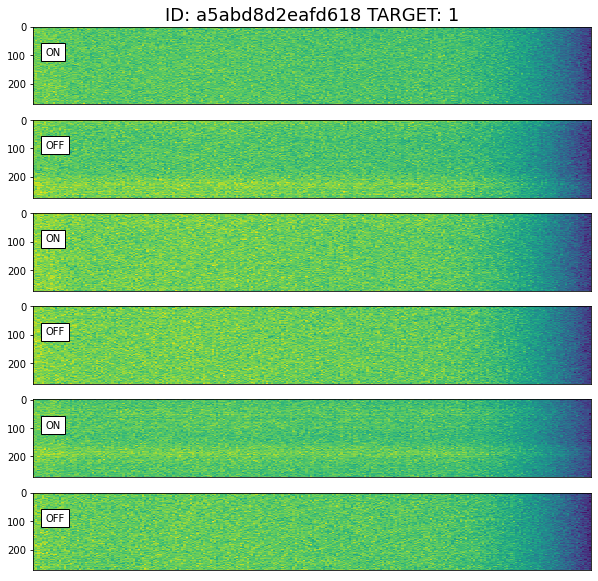

In [21]:
display_cadence(df_train, n_sample = 1, target = 1)

### Custom Dataset

In [22]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None):
		self.labels = df["target"].values
		self.file_names = df['file_path'].values
		self.transform = transform

	def __len__(self):
		return len(self.file_names)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)
		image = np.vstack(image).T
		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()
		image = torch.from_numpy(image).unsqueeze(dim=0)
		label = torch.tensor(self.labels[idx]).float()
		return image, label

In [ ]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.efficientnet = enet.EfficientNet.from_name(model_name)
        if not load_schnaufnet_model:
            print("Loading pretrained efficientnet model")
            pretrained_model = {
                model_name: conf_dict["efficientnetdir"] + conf_dict["efficientnet_pth"]
            }
            self.efficientnet.load_state_dict(torch.load(pretrained_model[model_name]))
        else:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.first_layer = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.final_layer = nn.Linear(self.efficientnet._fc.in_features, out_dim)
        self.efficientnet._fc = nn.Identity()

    def extract(self, x):
        return self.efficientnet(x)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.extract(x)
        x = self.final_layer(x)
        return x

In [ ]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")

    return train_dataloader, val_dataloader

In [ ]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_loss_list):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round()
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    epoch_loss_list.append(avg_epoch_loss)
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()

            predicted_raw = torch.sigmoid(pred)
            predicted = predicted_raw.round()

            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            labels = labels.detach().cpu().numpy().tolist()
            predicted_raw = predicted_raw.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted_raw)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    return epoch_labels, epoch_preds

In [ ]:
def get_transforms(data):
    if data == 'train':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
        ])
    elif data == 'val':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
        ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 1/5 | Epoch 1/2
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [58:21<00:00,  1.71it/s]  


Training Error: 
 
        Accuracy: 63.787500%, 

        Recall: 47.206271%, 

        Precision: 70.172596%, 

        Avg loss: 0.605525 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [12:39<00:00,  1.98it/s]


Validation Error: 

        Accuracy: 89.783333%, 

        Recall: 38.416667%, 

        Precision: 48.628692%, 

        Avg loss: 0.467224 

    
Val ROC AUC Score: 0.7426060185185185


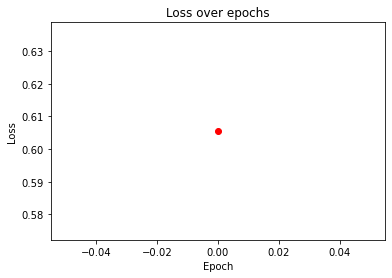

Fold 1/5 | Epoch 2/2
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [53:42<00:00,  1.86it/s]  


Training Error: 
 
        Accuracy: 92.239583%, 

        Recall: 27.562500%, 

        Precision: 84.213877%, 

        Avg loss: 0.260160 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [10:15<00:00,  2.44it/s]


Validation Error: 

        Accuracy: 91.933333%, 

        Recall: 19.916667%, 

        Precision: 97.154472%, 

        Avg loss: 0.269512 

    
Val ROC AUC Score: 0.7172048225308643


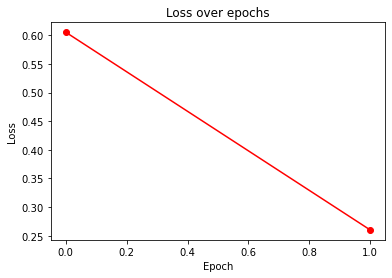

Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 2/5 | Epoch 1/2
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training:  18%|█▊        | 1097/6000 [07:58<35:38,  2.29it/s]


KeyboardInterrupt: 

In [ ]:
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss()
num_epochs = conf_dict["epochs"]
num_folds = conf_dict["folds"]
skf = StratifiedKFold(n_splits=num_folds)

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
    )
    best_roc_auc = 0
    best_roc_auc_fold = 1
    best_roc_auc_fold_epoch = 1
    epoch_train_loss_list = []
    for epoch in range(num_epochs):
        print(f"Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs}\n-------------------------------")
        if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
            print(f"Using {new_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        else:
            print(f"Using {current_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_train_loss_list)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
        plt.plot(epoch_train_loss_list, "ro-")
        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    break
print(f"Training done! Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")